In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics
os.chdir("..")
os.getcwd()

from platform import python_version
print(python_version())

import importlib.util

#spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src\\data_prep.py")
spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src/data_prep.py")
prep_data = importlib.util.module_from_spec(spec_data_pred)
spec_data_pred.loader.exec_module(prep_data)

#spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src\\plotting_printing.py")
spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src/plotting_printing.py")
plotting_printing = importlib.util.module_from_spec(spec_plotting_printing)
spec_plotting_printing.loader.exec_module(plotting_printing)

3.8.10


In [2]:

import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import numpy as np 

import pandas as pd
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
pd.set_option('display.max_rows', None)


In [3]:
def emnist_data_prep(results, results_val, min_epoch = 30, min_sample_size = 50100, min_acc = 0.1, epoch_freq = 10, max_sample_size = 100000):
    mask = results.epochs_trained >= min_epoch
    results = results[mask].reset_index(drop=True)
    mask = results.accs >= min_acc
    results = results[mask].reset_index(drop=True)
    mask = results_val.epochs_trained >= min_epoch
    results_val = results_val[mask].reset_index(drop=True)
    classes = results.columns.tolist()[2:-1]
    #classes
    print(classes)
    results["total_training_size"] = results[classes].sum(axis=1)
    mask = results.total_training_size > min_sample_size
    results = results[mask].reset_index(drop=True)
    mask = results.total_training_size < max_sample_size
    results = results[mask].reset_index(drop=True)
    #mask = (results.epochs_trained % 4 == 2)
    mask = (results.epochs_trained % epoch_freq == 0)
    results = results[mask].reset_index(drop=True)
    results_orig = results.copy()
    results_val["total_training_size"] = results_val[classes].sum(axis=1)
    mask = results_val.total_training_size > min_sample_size
    results_val = results_val[mask].reset_index(drop=True)
    mask = results_val.total_training_size < max_sample_size
    results_val = results_val[mask].reset_index(drop=True)
    mask = (results_val.epochs_trained % epoch_freq == 0)
    results_val = results_val[mask].reset_index(drop=True)
    results.head(4)
    print(results.shape)
    print(results.shape)
    results.total_training_size.unique()
    
    print(results[["accs"] + classes + ["epochs_trained", "total_training_size"]].iloc[:5, :].to_latex(float_format="{:.2f}".format))

    ### constructing a pred dataset: 
    results_pred = results[["training_times"] + classes + ["epochs_trained", "total_training_size"]].copy()
    row = {c: 2400 for c in classes}
    row["epochs_trained"] = 90
    row["total_training_size"] = 112800 
    row["training_times"] = 100
    results_pred = results_pred.append(row, ignore_index=True)
    row = {c: 2400 for c in classes}
    row["training_times"] = 45
    row["epochs_trained"] = 70
    row["total_training_size"] =  112800
    results_pred = results_pred.append(row, ignore_index=True)
    results_pred = results_pred.iloc[-2:,:].reset_index(drop=True)

    for c_max in classes:
        row = {c: 2120 for c in classes}
        row[c_max] = 2400
        row["epochs_trained"] = 90
        row["training_times"] = 100
        row["total_training_size"] =  2120 * 47 + 2400
        results_pred = results_pred.append(row, ignore_index=True)
        row["epochs_trained"] = 70
        results_pred = results_pred.append(row, ignore_index=True)
        row["epochs_trained"] = 50
        results_pred = results_pred.append(row, ignore_index=True)
        row["epochs_trained"] = 30
        results_pred = results_pred.append(row, ignore_index=True)
        
    for c_max in classes:
        row = {c: 1800 for c in classes}
        row[c_max] = 2400
        row["epochs_trained"] = 90
        row["training_times"] = 100
        row["total_training_size"] =  1800*46 + 2400
        results_pred = results_pred.append(row, ignore_index=True)
        row["epochs_trained"] = 70
        results_pred = results_pred.append(row, ignore_index=True)
        row["epochs_trained"] = 50
        results_pred = results_pred.append(row, ignore_index=True)
        row["epochs_trained"] = 30
        results_pred = results_pred.append(row, ignore_index=True)

    results_pred_orig = results_pred.copy()

    #scaler = preprocessing.MinMaxScaler()
    scaler = preprocessing.StandardScaler()
    scaler.fit(X = results.iloc[:, 1:])
    results_scaled = pd.DataFrame(scaler.transform(results.iloc[:, 1:]))
    results_scaled.columns = results.iloc[:, 1:].columns
    results = pd.concat([results["accs"], results_scaled], axis=1)
    results.head(2)
    # using the same scaler for val:
    results_scaled_val = pd.DataFrame(scaler.transform(results_val.iloc[:, 1:]))
    results_scaled_val.columns = results_val.iloc[:, 1:].columns
    results_val_orig = results_val.copy()
    results_val = pd.concat([results_val["accs"], results_scaled_val], axis=1)
    results_val.head(2)
    # using the same scaler for pred tries:
    results_scaled_pred = pd.DataFrame(scaler.transform(results_pred))
    results_scaled_pred.columns = results_pred.columns
    results_pred = results_scaled_pred
    results_pred
    xdata = np.transpose(results.to_numpy()[:, 2:])
    y = results.to_numpy()[:, 0]
    #xdata_val = np.transpose(results_val.to_numpy()[:, 2:-1])
    xdata_val = np.transpose(results_val.to_numpy()[:, 2:])
    y_val = results_val.to_numpy()[:, 0]
    xdata.shape
    #xdata_pred = np.transpose(results_pred.to_numpy()[:, 1:-1])
    xdata_pred = np.transpose(results_pred.to_numpy()[:, 1:])
    xdata_pred.shape
    mask = results.epochs_trained == 1
    results_last_epoch = results[mask].reset_index(drop=True)
    xdata_last_epoch = np.transpose(results_last_epoch.to_numpy()[:, 2:-2])
    y_last_epoch = results_last_epoch.to_numpy()[:, 0]
    mask = results_val.epochs_trained == 1
    results_val_last_epoch = results_val[mask].reset_index(drop=True)
    xdata_val_last_epoch = np.transpose(results_val_last_epoch.to_numpy()[:, 2:-2])
    y_val_last_epoch = results_val_last_epoch.to_numpy()[:, 0]
    # data for total_n and epoch only:
    xdata_total_n_epoch = np.transpose(results.to_numpy()[:, -2:])
    xdata_val_total_n_epoch = np.transpose(results_val.to_numpy()[:, -2:])
    xpred_total_n_epoch = np.transpose(results_pred.to_numpy()[:, -2:])
    xpred_total_n_epoch.shape

    # data for last epoch, total_n only:
    #xdata_last_epoch_total_n = np.transpose(results_last_epoch.to_numpy()[:, -1:])
    #xdata_val_last_epoch_total_n = np.transpose(results_val_last_epoch.to_numpy()[:, -1:])

    results_dict = {"classes": classes, 
                "xdata": xdata, 
                "y": y, 
                "xdata_val": xdata_val, 
                "y_val": y_val, 
                "xdata_pred": xdata_pred, 
                #"xdata_4500": xdata_4500, 
                #"y_4500": y_4500, 
                "results": results, 
                "results_orig": results_orig,
                "results_val": results_val, 
                "results_val_orig": results_val_orig, 
                #"results_4500": results_4500, 
                "results_pred": results_pred, 
                #"results_4500_orig": results_4500_orig, 
                "results_pred_orig": results_pred_orig, 
                "xdata_last_epoch": xdata_last_epoch, 
                "y_last_epoch": y_last_epoch, 
                "xdata_val_last_epoch": xdata_val_last_epoch, 
                "y_val_last_epoch": y_val_last_epoch, 
                "xdata_total_n_epoch": xdata_total_n_epoch, 
                "xdata_val_total_n_epoch": xdata_val_total_n_epoch}
    return results_dict

def emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim = (0.5, 1)):
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat = func(xdata, *params)
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    results[y_hat_name] = y_hat

    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim(xylim)
    plt.ylim(xylim)
    plt.axline((xylim[0], xylim[0]), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=xylim[0] + 0.05, y=xylim[1] - 0.05, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props, horizontalalignment='left', verticalalignment='top')
    plt.legend(loc = 'lower right')
    if saving_plots:
        plt.savefig(f"paper/plots/{model_type}_{y_hat_name}.jpg")
    plt.show()
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func(xdata_val, *params)
    print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim(xylim)
    plt.ylim(xylim)
    plt.axline((xylim[0], xylim[0]), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=xylim[0] + 0.05, y=xylim[1] - 0.05, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props, horizontalalignment='left', verticalalignment='top')
    plt.legend(loc = 'lower right')
    if saving_plots:
        plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_val.jpg")
    plt.show()

    print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")

    acc_pred = func(xdata_pred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.legend(loc = 'lower right')
    plt.show()
    display(results_pred_orig.head(2))

    if is_2param:
        param_unstacked = param_df.T.reset_index(drop=False).iloc[3:,:].param_name.str.split("_", expand=True).reset_index(drop=True)
        param_unstacked.columns = ["feature", "param_no"]
        param_unstacked["param_value"] = param_df.T.reset_index(drop=False).iloc[3:,:].reset_index(drop=True).param_value
        param_unstacked = param_unstacked.set_index(["feature", "param_no"])
        param_unstacked = param_unstacked.unstack()
        display(param_unstacked)

        param_unstacked.iloc[:,1]
        plt.scatter(param_unstacked.iloc[:,0], param_unstacked.iloc[:,1])
        plt.xlabel("parameter height")
        plt.ylabel("parameter width")
        for i in range(param_unstacked.shape[0]):
            plt.annotate(param_unstacked.reset_index().iloc[i,0], (param_unstacked.iloc[i,0] + 0.01, param_unstacked.iloc[i, 1]))
        if saving_plots:
            plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_param1_vs_param2.jpg")
        plt.show()


def emnist_forward_testing(results_orig_fit, results_orig_pred, results_pred, func, n_param_int, xdata_fit, y_fit, xdata_pred, y_hat_name, max_fev = 500000, bounds = (-10, 10)) -> pd.DataFrame:
    """
    

    """
    results_pred[y_hat_name+"_forward"] = None
    results_pred[y_hat_name+"_step"] = None
    steps = results_orig_fit.total_training_size.round(-2).unique().tolist()[1:]
    for i in range(len(steps) - 1):
        tr_upper = steps[i]
        print(tr_upper)
        pred_upper = steps[i + 1]
        mask = results_orig_fit.total_training_size.round(-1) <= tr_upper
        np.random.seed(seed=4213500023)
        p0 = np.random.uniform(low=0, high=1, size = n_param_int)
        converged = False
        #try:
        params, params_cov = curve_fit(func, xdata_fit[:, :mask.sum()], y_fit[:mask.sum()], maxfev=max_fev, p0=p0)
        #    converged = True
        #except:
        #    print("did not converge")
        mask_next = (tr_upper < results_orig_pred.total_training_size.round(-1)) & (results_orig_pred.total_training_size.round(-1) <= pred_upper)
        y_hat = func(xdata_pred, *params)
        #results[y_hat_name+"_forward_" + str(steps[i])] = y_hat
        results_pred.loc[mask_next, y_hat_name+"_forward"] = pd.Series(y_hat).loc[mask_next]
        results_pred.loc[mask_next, y_hat_name+"_step"] = steps[i]

    return results_pred


def emnist_plot_forward_testing(data, y_hat_name, xylim = (0.5, 1)):
    sns.scatterplot(data = data, x="accs", y = y_hat_name+"_forward", hue = y_hat_name+"_step")
    plt.xlim(xylim)
    plt.ylim(xylim)
    #plt.plot((0, 1), (0, 1),linestyle="dotted")
    plt.legend()#
    non_na_mask = ~data[y_hat_name+'_forward'].isna()
    #plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(data.accs.loc[non_na_mask], data[y_hat_name+'_forward'].loc[non_na_mask]), 3)}", bbox=props)
    plt.legend(loc = 'lower right')
    plt.show()

### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using emnist balanced data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### power law: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [4]:
model_type = "powerlaw_all_epochs"
dataset = "emnist"

In [5]:
#results_full_training = pd.read_csv("csv_files/Cifar10_acc_full_train_10_iterations_20230714.csv")
#results_full_training.head(20)
#mask = results_full_training.epoch == 195
#results_full_training[mask]

In [6]:
results = pd.read_csv("csv_files/emnist_train_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231103.csv")
results_val = pd.read_csv("csv_files/emnist_val_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231117.csv")

In [7]:
#results["total_training_size"] = results[classes].sum(axis=1)
#results.head(2)
#mask = (results.total_training_size > 10100) & (results.total_training_size < 20100)
#results[mask].accs.describe()

In [8]:
#a = 10100
#mask = (results.total_training_size > a) & (results.total_training_size < a + 10000) & (results.epochs_trained > 8)
#print(results[mask].accs.min(), results[mask].accs.max())


In [9]:
min_epoch = 2
min_sample_size = 100
min_acc = 0.01
epoch_freq = 8
max_sample_size = 170500


In [10]:
#112800 / 47 # number of images per class in full dataset
#100000/47
results.head(2)
#results.epochs_trained.unique()

,accs,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained
0,0.021277,4.356774,146.0,242.0,208.0,280.0,79.0,11.0,60.0,396.0,86.0,176.0,128.0,47.0,282.0,131.0,22.0,655.0,46.0,77.0,1935.0,157.0,118.0,1.0,182.0,33.0,27.0,213.0,15.0,122.0,76.0,45.0,178.0,217.0,179.0,34.0,73.0,1813.0,21.0,270.0,53.0,225.0,3.0,99.0,97.0,19.0,98.0,268.0,360.0,0
1,0.021277,5.514355,146.0,242.0,208.0,280.0,79.0,11.0,60.0,396.0,86.0,176.0,128.0,47.0,282.0,131.0,22.0,655.0,46.0,77.0,1935.0,157.0,118.0,1.0,182.0,33.0,27.0,213.0,15.0,122.0,76.0,45.0,178.0,217.0,179.0,34.0,73.0,1813.0,21.0,270.0,53.0,225.0,3.0,99.0,97.0,19.0,98.0,268.0,360.0,2


In [11]:
results_dict = emnist_data_prep(results, results_val, min_epoch = min_epoch, min_sample_size=min_sample_size, min_acc=min_acc, epoch_freq=epoch_freq, max_sample_size=max_sample_size)
locals().update(results_dict)



['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
(15400, 51)
(15400, 51)
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  accs &      0 &      1 &      2 &      3 &     4 &     5 &     6 &      7 &     8 &      9 &      A &     B &      C &      D &     E &      F &     G &     H &       I &      J &      K &    L &      M &     N &     O &      P &     Q &      R &     S &     T &      U &      V &      W &     X &     Y &       Z &     a &      b &     d &      e &    f &     g &     h &     n &     q &      r &      t &  epochs\_trained &  total\_training\_size \\
\midrule
0 &  0.02 & 146.00 & 242.00 & 208.00 & 280.00 & 79.00 & 11.00 & 60.00 & 396.00 & 86.00 & 176.00 & 128.00 & 47.00 & 282.00 & 131.00 & 22.00 & 655.00 & 46.00 & 77.00 & 1935.00 & 157.00 & 118.00 & 1

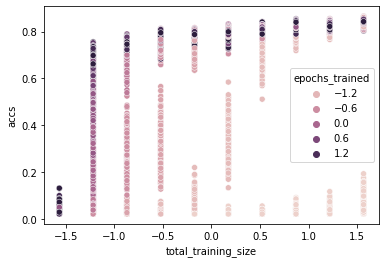

In [12]:
sns.scatterplot(data=results, x = "total_training_size", y = "accs", hue = "epochs_trained")
plt.show()

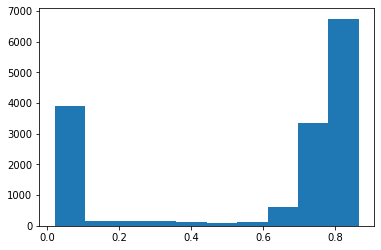

In [13]:
plt.hist(results.accs)
plt.show()

In [14]:
print(results_orig.accs.min(), results_orig.accs.max())
print(results_orig.total_training_size.min())
print(results_orig.epochs_trained.min(), results_orig.epochs_trained.max())
print(results_orig.epochs_trained.unique())
print(xdata.shape, results_orig.shape)
results_orig.head(2)

0.0212765957446808 0.8650531914893617
9995.0
8 88
[ 8 16 24 32 40 48 56 64 72 80 88]
(49, 15400) (15400, 51)


,accs,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size
0,0.021277,5.540749,146.0,242.0,208.0,280.0,79.0,11.0,60.0,396.0,86.0,176.0,128.0,47.0,282.0,131.0,22.0,655.0,46.0,77.0,1935.0,157.0,118.0,1.0,182.0,33.0,27.0,213.0,15.0,122.0,76.0,45.0,178.0,217.0,179.0,34.0,73.0,1813.0,21.0,270.0,53.0,225.0,3.0,99.0,97.0,19.0,98.0,268.0,360.0,8,10003.0
1,0.021277,5.523631,146.0,242.0,208.0,280.0,79.0,11.0,60.0,396.0,86.0,176.0,128.0,47.0,282.0,131.0,22.0,655.0,46.0,77.0,1935.0,157.0,118.0,1.0,182.0,33.0,27.0,213.0,15.0,122.0,76.0,45.0,178.0,217.0,179.0,34.0,73.0,1813.0,21.0,270.0,53.0,225.0,3.0,99.0,97.0,19.0,98.0,268.0,360.0,16,10003.0


### pure arctan

In [15]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b, c, *args) -> float:
    running_sum = 0    
    for i in range(n_param):
        running_sum += args[i] * x[i]
    return a + (np.arctan(running_sum + b)) * c

np.random.seed(seed=42135023)
n_p = len(classes) + 3 + 1
n_param = len(classes) + 1
p0 = np.random.uniform(low = 0, high=1, size = n_p)
#p0[-1] = 300
#params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))
#params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0)
bounds = (np.repeat(0, n_p), np.repeat(10, n_p))
params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0, bounds = bounds)

print(params.shape, len(classes))
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch"]


(51,) 47


param_name,a,b,c,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epoch
param_value,0.366682,1.781386,0.326728,0.072634,0.034717,0.066473,0.035073,0.049389,0.042506,0.076133,0.065556,0.028148,0.047266,0.06322,0.066412,0.093387,0.119576,0.04262,0.026156,0.03169,0.071774,0.072909,0.039583,0.061885,0.045572,0.057567,0.081207,0.087614,0.057126,0.087764,0.060435,0.065068,0.074452,0.071761,0.050887,0.056253,0.084094,0.053632,0.065138,0.058893,0.04143,0.062235,0.048302,0.055134,0.101134,0.03454,0.092261,0.070108,0.046736,0.040306,1.394501


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &    0 &    1 &    2 &    3 &    4 &    5 &    6 &    7 &    8 &    9 &    A &    B &    C &    D &    E &    F &    G &    H &    I &    J &    K &    L &    M &    N &    O &    P &    Q &    R &    S &    T &    U &    V &    W &    X &    Y &    Z &    a &    b &    d &    e &    f &    g &    h &    n &    q &    r &    t &  epoch \\
\midrule
param\_value & 0.37 & 1.78 & 0.33 & 0.07 & 0.03 & 0.07 & 0.04 & 0.05 & 0.04 & 0.08 & 0.07 & 0.03 & 0.05 & 0.06 & 0.07 & 0.09 & 0.12 & 0.04 & 0.03 & 0.03 & 0.07 & 0.07 & 0.04 & 0.06 & 0.05 & 0.06 & 0.08 & 0.09 & 0.06 & 0.09 & 0.06 & 0.07 & 0.07 & 0.07 & 0.05 & 0.06 & 0.08 & 0.05 & 0.07 & 0.06 & 0.04 & 0.06 & 0.05 & 0.06 & 0.10 & 0.03 & 0.09 & 0.07 & 0.05 & 0.04 &   1.39 \\
\bottomrule
\end{tabular}

0.03342673597888394


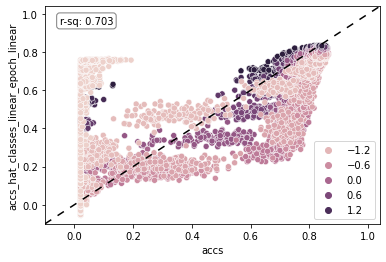

0.70318733853694
mean val loss: 0.033909206361818205


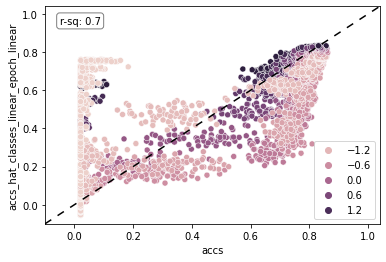

r_square val: 0.699930357871849


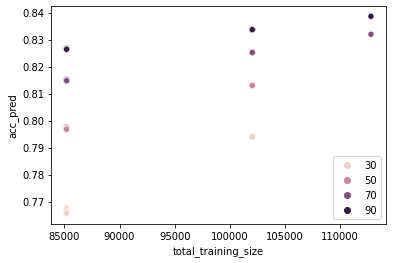

,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size,acc_pred
0,100.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,90,112800.0,0.838606
1,45.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,70,112800.0,0.831967


In [16]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim=(-0.1, 1.04))


In [49]:
xdata.shape

(49, 15400)

In [56]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b, c, *args) -> float:
    running_sum = 0    
    for i in range(n_param):
        running_sum += args[i] * x[i]
    interaction = args[n_param] * x[n_param] * x[n_param - 1] # an interaction between total training size and epoch     
    return a + (np.arctan(running_sum + interaction + b)) * c

np.random.seed(seed=42135023)
n_p = len(classes) + 3 + 2
n_param = len(classes) + 1
p0 = np.random.uniform(low = 0, high=1, size = n_p)
#p0[-1] = 300
#params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))
#params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0)
bounds = (np.repeat(-60, n_p), np.repeat(60, n_p))
params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0, bounds = bounds)

print(params.shape, len(classes))
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "interaction"]


(52,) 47


In [ ]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b, c, *args) -> float:
    running_sum = 0    
    for i in range(n_param):
        running_sum += args[i] * x[i]
    interaction = args[n_param] * x[n_param] * x[n_param - 1] # an interaction between total training size and epoch     
    return a + (np.arctan(running_sum + interaction + b)) * c

np.random.seed(seed=42135023)
n_p = len(classes) + 3 + 2
n_param = len(classes) + 1
p0 = np.random.uniform(low = 0, high=1, size = n_p)
#p0[-1] = 300
#params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))
#params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0)
bounds = (np.repeat(-60, n_p), np.repeat(60, n_p))
params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0, bounds = bounds)

print(params.shape, len(classes))
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "interaction"]


(52,) 47


param_name,a,b,c,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epoch,interaction
param_value,0.393156,17.854456,0.26629,0.579535,0.481971,0.516809,0.477819,0.463664,0.512189,0.553226,0.460957,0.527781,0.523769,0.524566,0.463263,0.551346,0.530524,0.512746,0.54856,0.524397,0.527149,0.474451,0.456923,0.517641,0.479179,0.473824,0.491806,0.565734,0.502734,0.506109,0.538099,0.517067,0.459888,0.516205,0.485483,0.423471,0.508758,0.419974,0.550523,0.507442,0.478997,0.543347,0.514474,0.51288,0.565392,0.514942,0.538336,0.600441,0.471541,0.466894,14.904479,8.562412


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &     b &    c &    0 &    1 &    2 &    3 &    4 &    5 &    6 &    7 &    8 &    9 &    A &    B &    C &    D &    E &    F &    G &    H &    I &    J &    K &    L &    M &    N &    O &    P &    Q &    R &    S &    T &    U &    V &    W &    X &    Y &    Z &    a &    b &    d &    e &    f &    g &    h &    n &    q &    r &    t &  epoch &  interaction \\
\midrule
param\_value & 0.39 & 17.85 & 0.27 & 0.58 & 0.48 & 0.52 & 0.48 & 0.46 & 0.51 & 0.55 & 0.46 & 0.53 & 0.52 & 0.52 & 0.46 & 0.55 & 0.53 & 0.51 & 0.55 & 0.52 & 0.53 & 0.47 & 0.46 & 0.52 & 0.48 & 0.47 & 0.49 & 0.57 & 0.50 & 0.51 & 0.54 & 0.52 & 0.46 & 0.52 & 0.49 & 0.42 & 0.51 & 0.42 & 0.55 & 0.51 & 0.48 & 0.54 & 0.51 & 0.51 & 0.57 & 0.51 & 0.54 & 0.60 & 0.47 & 0.47 &  14.90 &         8.56 \\
\bottomrule
\end{tabular}

0.0014267107087669404


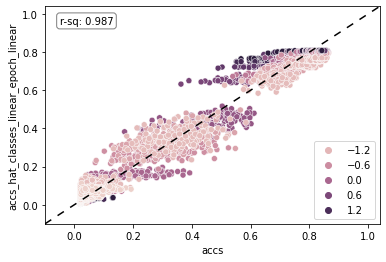

0.9873315239970043
mean val loss: 0.0015312469347371815


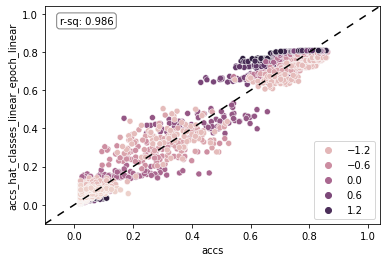

r_square val: 0.986449676385414


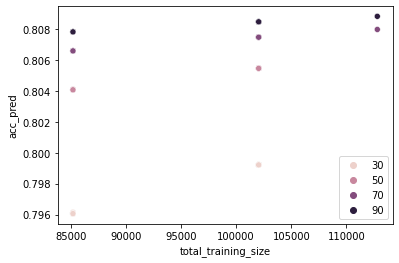

,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size,acc_pred
0,100.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,90,112800.0,0.808851
1,45.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,70,112800.0,0.808000


In [57]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim=(-0.1, 1.04))


20000.0
30000.0
40000.0
50000.0
60000.0
70000.0
80000.0
90000.0


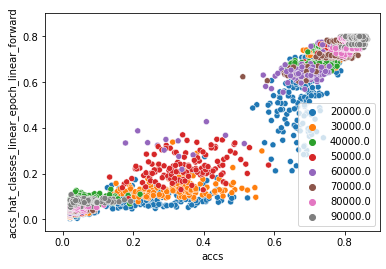

In [58]:
results = emnist_forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name, max_fev=500000)
emnist_plot_forward_testing(results, y_hat_name,xylim = (-0.05, 0.9))
#results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
#plotting_printing.plot_forward_testing(results_val, y_hat_name)

In [40]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b, c, *args) -> float:
    running_sum = 0
    interaction_sum = 0    
    for i in range(n_param):
        running_sum += args[i] * x[i]
        interaction_sum += args[n_param + i] * x[i] * x[n_param - 1] 
    #interaction = args[n_param] * x[n_param] * x[n_param - 1] # an interaction between total training size and epoch     
    return a + (np.arctan(running_sum + interaction_sum + b)) * c

np.random.seed(seed=42135023)
n_p = 2*len(classes) + 3 + 2 
n_param = len(classes) + 1
p0 = np.random.uniform(low = 0, high=1, size = n_p)
#p0[-1] = 300
#params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))
#params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0)
bounds = (np.repeat(0, n_p), np.repeat(10, n_p))
params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0, bounds = bounds)

print(params.shape, len(classes))
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch"] + [f"{c}_i" for c in classes] + ["epoch_sq"]


(99,) 47


param_name,a,b,c,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epoch,0_i,1_i,2_i,3_i,4_i,5_i,6_i,7_i,8_i,9_i,A_i,B_i,C_i,D_i,E_i,F_i,G_i,H_i,I_i,J_i,K_i,L_i,M_i,N_i,O_i,P_i,Q_i,R_i,S_i,T_i,U_i,V_i,W_i,X_i,Y_i,Z_i,a_i,b_i,d_i,e_i,f_i,g_i,h_i,n_i,q_i,r_i,t_i,epoch_sq
param_value,0.379649,10.0,0.286258,0.39488,0.279768,0.296209,0.257503,0.222261,0.242447,0.356439,0.238458,0.304882,0.33849,0.295083,0.234949,0.303641,0.306003,0.257346,0.373396,0.307814,0.316052,0.319712,0.207641,0.284227,0.263167,0.267609,0.253791,0.361525,0.258825,0.297136,0.308806,0.277492,0.242951,0.27774,0.247697,0.175597,0.256733,0.182643,0.318632,0.276519,0.255275,0.295548,0.323876,0.294897,0.31596,0.260271,0.316854,0.405479,0.241341,0.215283,8.343999,0.224883,0.158105,0.161239,0.141928,0.107518,0.106544,0.209638,0.136346,0.161602,0.202352,0.153375,0.130295,0.146578,0.167917,0.12314,0.230498,0.161173,0.176484,0.209201,0.111748,0.140063,0.153326,0.154053,0.134153,0.208427,0.121842,0.169262,0.160442,0.140967,0.143118,0.147948,0.126101,0.084902,0.119474,0.093323,0.161953,0.14186,0.138875,0.152515,0.18766,0.170916,0.162705,0.122579,0.176261,0.22441,0.12577,0.108588,2.788592e-18


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &     b &    c &    0 &    1 &    2 &    3 &    4 &    5 &    6 &    7 &    8 &    9 &    A &    B &    C &    D &    E &    F &    G &    H &    I &    J &    K &    L &    M &    N &    O &    P &    Q &    R &    S &    T &    U &    V &    W &    X &    Y &    Z &    a &    b &    d &    e &    f &    g &    h &    n &    q &    r &    t &  epoch &  0\_i &  1\_i &  2\_i &  3\_i &  4\_i &  5\_i &  6\_i &  7\_i &  8\_i &  9\_i &  A\_i &  B\_i &  C\_i &  D\_i &  E\_i &  F\_i &  G\_i &  H\_i &  I\_i &  J\_i &  K\_i &  L\_i &  M\_i &  N\_i &  O\_i &  P\_i &  Q\_i &  R\_i &  S\_i &  T\_i &  U\_i &  V\_i &  W\_i &  X\_i &  Y\_i &  Z\_i &  a\_i &  b\_i &  d\_i &  e\_i &  f\_i &  g\_i &  h\_i &  n\_i &  q\_i &  r\_i &  t\_i &  epoch\_sq \\
\midrule
param\_value & 0.38 & 10.00 & 0.29 & 0.39 & 0.28 & 0.30 & 0.26 & 0.22 & 0.24 & 0.36 & 0.24 & 0.30 & 

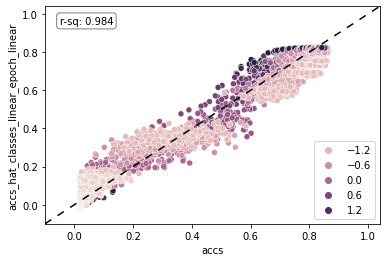

0.98382732001706
mean val loss: 0.0019202853339529734


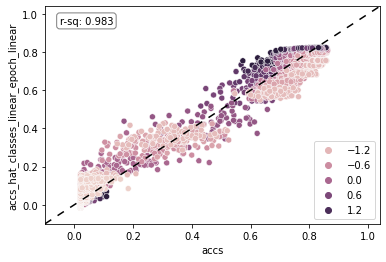

r_square val: 0.9830069944193083


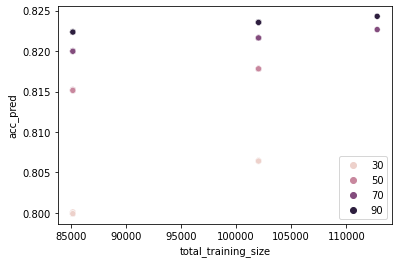

,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size,acc_pred
0,100.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,90,112800.0,0.824300
1,45.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,70,112800.0,0.822664


In [41]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim=(-0.1, 1.04))


In [59]:
# one option without the class sample sizes:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b, c, d, e, f) -> float:
    running_sum = d * x[n_param - 1] + e * x[n_param]
    interaction = f * x[n_param] * x[n_param - 1] # an interaction between total training size and epoch     
    return a + (np.arctan(running_sum + interaction + b)) * c

np.random.seed(seed=42135023)
n_p = 6 
n_param = len(classes) + 1
p0 = np.random.uniform(low = 0, high=1, size = n_p)
#p0[-1] = 300
#params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))
#params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0)
bounds = (np.repeat(-60, n_p), np.repeat(60, n_p))
params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0, bounds = bounds)

print(params.shape, len(classes))
param_names = ["a", "b", "c"]
param_names = param_names +  ["epoch", "total_size", "interaction"]


(6,) 47


param_name,a,b,c,epoch,total_size,interaction
param_value,0.39297,17.587067,0.266583,14.679448,15.439818,8.426818


\begin{tabular}{lrrrrrr}
\toprule
param\_name &    a &     b &    c &  epoch &  total\_size &  interaction \\
\midrule
param\_value & 0.39 & 17.59 & 0.27 &  14.68 &       15.44 &         8.43 \\
\bottomrule
\end{tabular}

0.001519250668350998


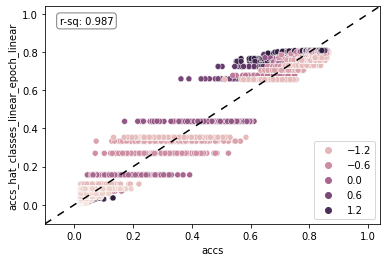

0.9865098155384465
mean val loss: 0.0015493712661852654


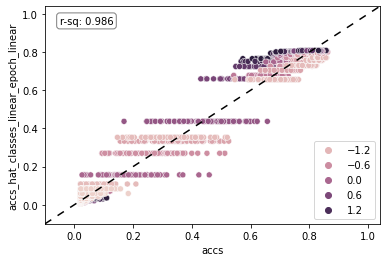

r_square val: 0.9862892903948541


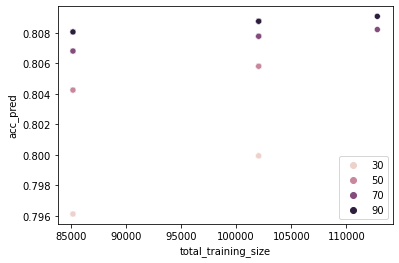

,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size,acc_pred
0,100.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,90,112800.0,0.809083
1,45.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,70,112800.0,0.808218


In [60]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim=(-0.1, 1.04))


20000.0
30000.0
40000.0
50000.0
60000.0
70000.0
80000.0
90000.0


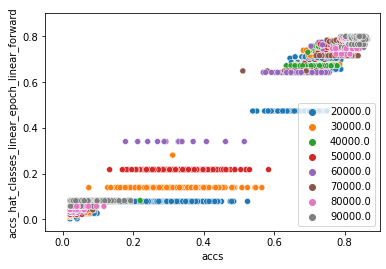

In [46]:
results = emnist_forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name, max_fev=500000)
emnist_plot_forward_testing(results, y_hat_name,xylim = (-0.05, 0.9))
#results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
#plotting_printing.plot_forward_testing(results_val, y_hat_name)

# powerlaw - full linear option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [19]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b, c, *args) -> float:
    running_sum = 0    
    for i in range(n_param):
        running_sum += args[i] * x[i]  
    #interaction = args[n_param] * x[n_param] * x[n_param - 1] # an interaction between total training size and epoch        
    return a + ((running_sum)**b) * c

np.random.seed(seed=42135023)
n_p = len(classes) + 3 + 1 
n_param = len(classes) + 1
p0 = np.random.uniform(low = -1, high=1, size = n_p)
#p0[-1] = 300
#params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))
params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0)
#bounds = (np.repeat(0, n_p), np.repeat(10, n_p))
#params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0, bounds = bounds)

print(params.shape, len(classes))
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch"]


(51,) 47


/tmp/ipykernel_34592/1394606267.py:8: RuntimeWarning: invalid value encountered in power
  return a + ((running_sum)**b) * c
/home/ubuntu/.pyenv/versions/3.8.10/envs/venv_tdss/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
print(xdata.shape, results.shape)


param_name,a,b,c,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epoch
param_value,0.252182,0.215591,0.919389,0.193455,-0.762991,-0.481349,0.856036,0.75337,-0.297033,0.372766,0.412636,-0.923145,0.737317,-0.815249,0.874473,0.994361,0.130674,-0.657995,0.45364,0.824853,0.607887,0.541804,-0.540921,0.415218,0.559645,-0.93995,0.614159,0.781554,-0.531302,-0.235885,0.753241,-0.661671,0.933077,0.840353,0.101153,0.84844,0.139408,-0.375499,0.419711,0.19285,0.420942,0.33623,0.342545,-0.024631,-0.819611,-0.373772,0.462214,0.280063,-0.299996,0.320697,-0.868674


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &    0 &     1 &     2 &    3 &    4 &     5 &    6 &    7 &     8 &    9 &     A &    B &    C &    D &     E &    F &    G &    H &    I &     J &    K &    L &     M &    N &    O &     P &     Q &    R &     S &    T &    U &    V &    W &    X &     Y &    Z &    a &    b &    d &    e &     f &     g &     h &    n &    q &     r &    t &  epoch \\
\midrule
param\_value & 0.25 & 0.22 & 0.92 & 0.19 & -0.76 & -0.48 & 0.86 & 0.75 & -0.30 & 0.37 & 0.41 & -0.92 & 0.74 & -0.82 & 0.87 & 0.99 & 0.13 & -0.66 & 0.45 & 0.82 & 0.61 & 0.54 & -0.54 & 0.42 & 0.56 & -0.94 & 0.61 & 0.78 & -0.53 & -0.24 & 0.75 & -0.66 & 0.93 & 0.84 & 0.10 & 0.85 & 0.14 & -0.38 & 0.42 & 0.19 & 0.42 & 0.34 & 0.34 & -0.02 & -0.82 & -0.37 & 0.46 & 0.28 & -0.30 & 0.32 &  -0.87 \\
\bottomrule
\end{tabular}

nan


/tmp/ipykernel_34592/1394606267.py:8: RuntimeWarning: invalid value encountered in power
  return a + ((running_sum)**b) * c


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

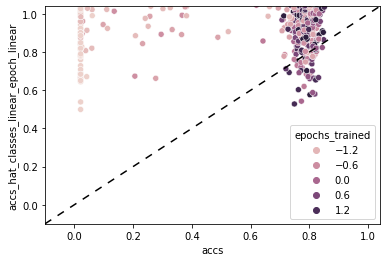

In [20]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim=(-0.1, 1.04))


In [ ]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b, c, *args) -> float:
    running_sum = 0    
    for i in range(n_param):
        running_sum += args[i] * x[i]
    epoch_effect = args[n_param] * x[n_param] + args[n_param + 1] * x[n_param] ** 2
    running_sum += epoch_effect
    return a + ((running_sum)**b) * c

np.random.seed(seed=4213523)
n_p = len(classes) + 3 + 2
n_param = len(classes)
p0 = np.random.uniform(low=0, high=1, size = n_p)

#params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))
params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0)

print(params.shape, len(classes))

In [ ]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch_1", "epoch_2"]
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim=(-0.1, 1.04))


In [ ]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b1, c1, *args) -> float:
    running_sum = 0    
    for i in range(n_param):
        running_sum += args[i] * x[i]
    #epoch_effect = args[n_param] * x[n_param] + args[n_param + 1] * x[n_param] ** 2
    #running_sum += epoch_effect
    epoch_effect = args[n_param]* np.arctan(args[n_param + 1] * x[n_param])
    return a + ((running_sum)**b1) * c1 + epoch_effect

np.random.seed(seed=42135203)
n_p = len(classes) + 3 + 2
n_param = len(classes)
p0 = np.random.uniform(low= 0, high=10, size = n_p)

#params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))
params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0)

print(params.shape, len(classes))

In [ ]:
results.head(2)

In [ ]:
sns.scatterplot(data=results, x = "total_training_size", y = "accs", hue = "epochs_trained")
plt.show()
sns.scatterplot(data=results, x = "accs", y = y_hat_name,hue = "total_training_size")
plt.show()

In [ ]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch_1", "epoch_2"]
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim=(-0.1, 1.04))


In [ ]:
results = emnist_forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name, max_fev=500000)
emnist_plot_forward_testing(results, y_hat_name)
#results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
#plotting_printing.plot_forward_testing(results_val, y_hat_name)

In [ ]:
### trying out log scaling  

y_hat_name = "accs_hat_classes_arctan_epoch_artan"

def func(x, a, b1, b2, c1, c2, *args) -> float:
    running_sum = 0
    # n_param is implicitely handed over, in order to not introduce a further parameter into curve_fit    
    for i in range(n_param - 1):
        running_sum += args[i]* x[i]                 
    return a + np.log(running_sum + b1) * c1 + np.log(args[n_param - 1] * x[n_param - 1] + b2) * c2

# this cell runs approx. 7 minutes
np.random.seed(seed=4213523)
n_p = len(classes) + 5 + 1 
n_param = len(classes) + 1
p0 = np.random.uniform(low=0, high=1, size = n_p)
bounds = (np.repeat(0, n_p), np.repeat(20, n_p))
#params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0)
params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0, bounds=bounds)
# strange enough, with bounds the optimzation takes way longer
# params, params_cov = curve_fit(func, xdata, y, maxfev=20000, p0=p0, bounds=(-10, 30)) 

param_names = ["a", "b1", "b2", "c1", "c2"]
for c in classes:
    param_names = param_names + [f"{c}_1"]
param_names = param_names + ["epoch_1"]


In [ ]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim=(0.0, 0.995))


In [ ]:
### trying out log scaling  

y_hat_name = "accs_hat_classes_arctan_epoch_artan"

def func(x, a, b, c, *args) -> float:
    running_sum = 0
    # n_param is implicitely handed over, in order to not introduce a further parameter into curve_fit    
    for i in range(n_param):
        running_sum += args[i]* x[i]                 
    return a + np.log(running_sum + b) * c

# this cell runs approx. 7 minutes
np.random.seed(seed=4213523)
n_p = len(classes) + 3 + 1 
n_param = len(classes) + 1
p0 = np.random.uniform(low=0, high=1, size = n_p)
bounds = (np.repeat(0, n_p), np.repeat(20, n_p))
#params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0)
params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0, bounds=bounds)
# strange enough, with bounds the optimzation takes way longer
# params, params_cov = curve_fit(func, xdata, y, maxfev=20000, p0=p0, bounds=(-10, 30)) 

param_names = ["a", "b", "c"]
for c in classes:
    param_names = param_names + [f"{c}_1"]
param_names = param_names + ["epoch_1"]


In [ ]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False, xylim=(0.0, 0.995))


### using an arctan effect for every class:

In [22]:
y_hat_name = "accs_hat_classes_arctan_epoch_artan"

def func(x, a, b, c, *args) -> float:
    running_sum = 0
    # n_param is implicitely handed over, in order to not introduce a further parameter into curve_fit    
    for i in range(n_param):
        running_sum += args[2*i]* np.arctan(args[2*i + 1] * x[i])         
    return a + ((running_sum)**b) * c
    #return a + (np.arctan(running_sum + b)) * c


# this cell runs approx. 7 minutes
np.random.seed(seed=42131523)
n_p = 2 * len(classes) + 3 + 2 
n_param = len(classes) + 1
p0 = np.random.uniform(low=-10, high=10, size = n_p)
bounds = (np.repeat(0, n_p), np.repeat(20, n_p))
params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0)
#params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0, bounds=bounds)
# strange enough, with bounds the optimzation takes way longer
# params, params_cov = curve_fit(func, xdata, y, maxfev=20000, p0=p0, bounds=(-10, 30)) 

param_names = ["a", "b", "c"]
for c in classes:
    param_names = param_names + [f"{c}_1", f"{c}_2"]
param_names = param_names + ["epoch_1", "epoch_2"]


/tmp/ipykernel_34592/685346936.py:8: RuntimeWarning: invalid value encountered in power
  return a + ((running_sum)**b) * c
/home/ubuntu/.pyenv/versions/3.8.10/envs/venv_tdss/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


param_name,a,b,c,0_1,0_2,1_1,1_2,2_1,2_2,3_1,3_2,4_1,4_2,5_1,5_2,6_1,6_2,7_1,7_2,8_1,8_2,9_1,9_2,A_1,A_2,B_1,B_2,C_1,C_2,D_1,D_2,E_1,E_2,F_1,F_2,G_1,G_2,H_1,H_2,I_1,I_2,J_1,J_2,K_1,K_2,L_1,L_2,M_1,M_2,N_1,N_2,O_1,O_2,P_1,P_2,Q_1,Q_2,R_1,R_2,S_1,S_2,T_1,T_2,U_1,U_2,V_1,V_2,W_1,W_2,X_1,X_2,Y_1,Y_2,Z_1,Z_2,a_1,a_2,b_1,b_2,d_1,d_2,e_1,e_2,f_1,f_2,g_1,g_2,h_1,h_2,n_1,n_2,q_1,q_2,r_1,r_2,t_1,t_2,epoch_1,epoch_2
param_value,5.427395,0.956129,-3.594014,8.832078,6.147063,9.545319,-9.180913,3.857326,1.342755,-5.247841,5.513159,6.884658,-5.63837,9.893495,3.531379,-5.081304,4.775697,8.044109,6.780984,-8.951048,0.244975,-9.925815,3.795649,5.269826,-1.44047,-5.631604,-4.225854,-2.322534,-4.313496,-6.339077,3.846446,2.397789,8.93466,-8.597649,4.74009,-0.933973,6.62497,-1.924547,-5.001761,4.279933,-2.789018,-8.051023,6.648228,6.409402,8.863066,-7.195633,2.41406,0.663833,2.999202,3.868949,6.033023,1.78706,1.1493,2.467198,6.203135,9.240831,-6.644609,-0.901479,4.639181,8.38061,-2.626606,-6.588654,-7.645593,-6.466624,0.22753,-6.025014,7.73601,8.372,-4.277629,-3.942312,8.641776,9.150967,3.256787,-7.91684,6.300347,-4.838672,9.306018,-8.382384,2.013422,7.943729,2.722748,-6.469435,-6.801405,-1.549623,7.411764,6.276803,-1.733639,-9.56347,-5.592865,-8.623963,6.064192,-1.528576,6.208542,-2.036434,-3.218678,2.822281,4.984708,3.349165,4.438104


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &     c &  0\_1 &  0\_2 &  1\_1 &   1\_2 &  2\_1 &  2\_2 &   3\_1 &  3\_2 &  4\_1 &   4\_2 &  5\_1 &  5\_2 &   6\_1 &  6\_2 &  7\_1 &  7\_2 &   8\_1 &  8\_2 &   9\_1 &  9\_2 &  A\_1 &   A\_2 &   B\_1 &   B\_2 &   C\_1 &   C\_2 &   D\_1 &  D\_2 &  E\_1 &  E\_2 &   F\_1 &  F\_2 &   G\_1 &  G\_2 &   H\_1 &   H\_2 &  I\_1 &   I\_2 &   J\_1 &  J\_2 &  K\_1 &  K\_2 &   L\_1 &  L\_2 &  M\_1 &  M\_2 &  N\_1 &  N\_2 &  O\_1 &  O\_2 &  P\_1 &  P\_2 &  Q\_1 &   Q\_2 &   R\_1 &  R\_2 &  S\_1 &   S\_2 &   T\_1 &   T\_2 &   U\_1 &  U\_2 &   V\_1 &  V\_2 &  W\_1 &   W\_2 &   X\_1 &  X\_2 &  Y\_1 &  Y\_2 &   Z\_1 &  Z\_2 &   a\_1 &  a\_2 &   b\_1 &  b\_2 &  d\_1 &  d\_2 &   e\_1 &   e\_2 &   f\_1 &  f\_2 &  g\_1 &   g\_2 &   h\_1 &   h\_2 &   n\_1 &  n\_2 &   q\_1 &  q\_2 &   r\_1 &   r\_2 &  t\_1 &  t\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\_val

/tmp/ipykernel_34592/685346936.py:8: RuntimeWarning: invalid value encountered in power
  return a + ((running_sum)**b) * c


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

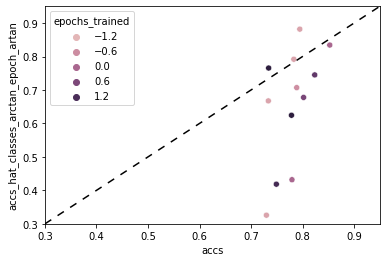

In [23]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=True, xylim=(0.3, 0.95))


In [ ]:
y_hat_name = "accs_hat_classes_arctan_epoch_artan"

def func(x, a, b, c, *args) -> float:
    running_sum = 0
    # n_param is implicitely handed over, in order to not introduce a further parameter into curve_fit    
    for i in range(n_param):
        running_sum += args[2*i]* np.arctan(args[2*i + 1] * x[i])         
    return a + ((running_sum)**b) * c

# this cell runs approx. 7 minutes
np.random.seed(seed=4213523)
n_p = 2 * len(classes) + 3 + 2 
n_param = len(classes) + 1
p0 = np.random.uniform(low=0, high=1, size = n_p)
bounds = (np.repeat(0, n_p), np.repeat(20, n_p))
#params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0)
params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0, bounds=bounds)
# strange enough, with bounds the optimzation takes way longer
# params, params_cov = curve_fit(func, xdata, y, maxfev=20000, p0=p0, bounds=(-10, 30)) 

param_names = ["a", "b", "c"]
for c in classes:
    param_names = param_names + [f"{c}_1", f"{c}_2"]
param_names = param_names + ["epoch_1", "epoch_2"]


In [ ]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=True, xylim=(0.3, 0.95))


In [ ]:
results = emnist_forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
emnist_plot_forward_testing(results, y_hat_name)

# using all epochs, but just overall training dataset size:

In [ ]:
#
y_hat_name = "accs_hat_total_n_epoch"

def func(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float) -> float:
    x_epoch = x[47]
    x_total_n = x[48]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch)**b) * c

np.random.seed(seed=4342133)
n_p = 5
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

In [ ]:
param_names = ["a", "b", "c"]
param_names = param_names + ["total_n", "epoch"]

In [ ]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False)


### Using the arctan trick also for the total_n model:

In [ ]:
y_hat_name = "accs_hat_total_n_arctan_epoch_arctan"

def func(x, a: float, b: float, c: float, d_total_n:float, d_total_n_2:float, d_epochs:float, d_epochs_2:float) -> float:
    x_epoch = x[47]
    x_total_n = x[48]
    return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c

np.random.seed(seed=92548)
n_p = 7
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0)
    converged = True
except:
    print("did not converge")

param_names = ["a", "b", "c"]
param_names = param_names + ["total_n_1", "total_n_2", "epoch_1", "epoch_2"]

In [ ]:
emnist_plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False)
